In [1]:
%matplotlib inline

In [2]:
image_path = "./assets/cat.jpeg"
image_path2 = "./assets/cat-2.jpg"
video_path = "./assets/cat.mp4"

## Multi-Modal Properties

Image Shape (H,W,channel): (753, 500, 3)
Pixel 0,0 [39 40 38]



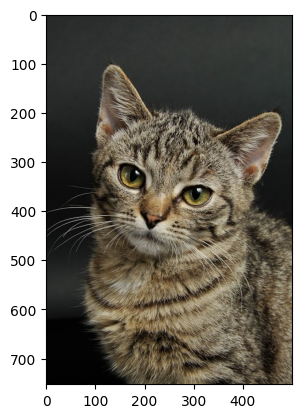

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

image = cv2.imread(image_path)
print(f"Image Shape (H,W,channel): {image.shape}")
print(f"Pixel 0,0 {image[0][0]}")
print()

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

Total Frames: 397
Frames per second: 29


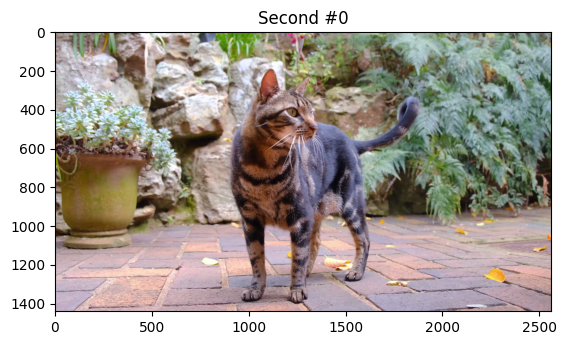

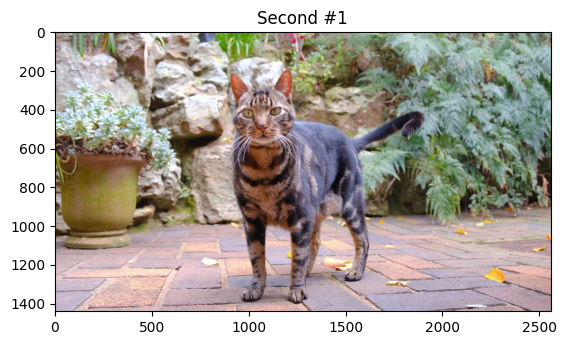

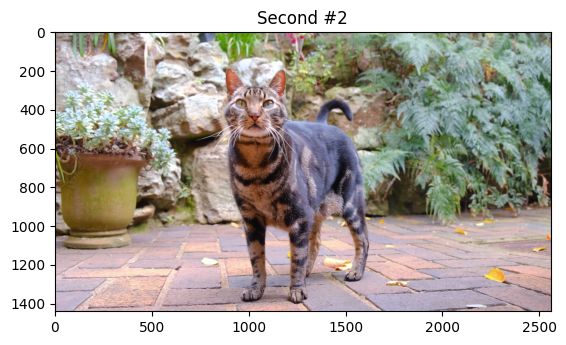

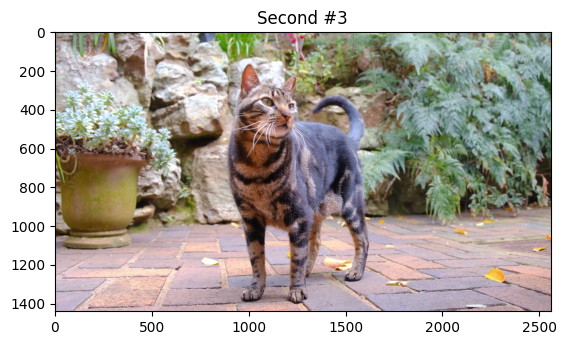

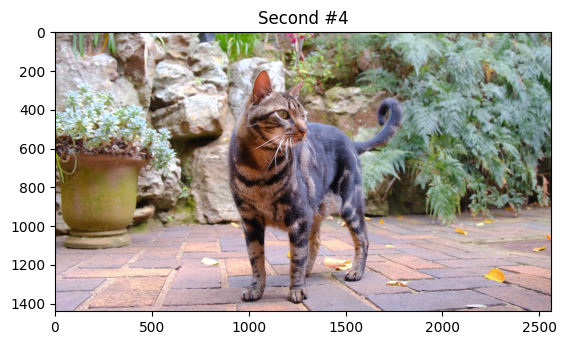

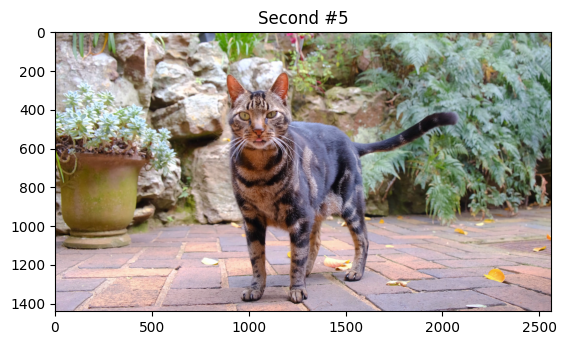

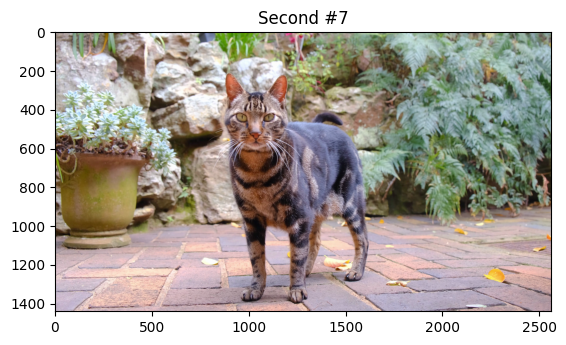

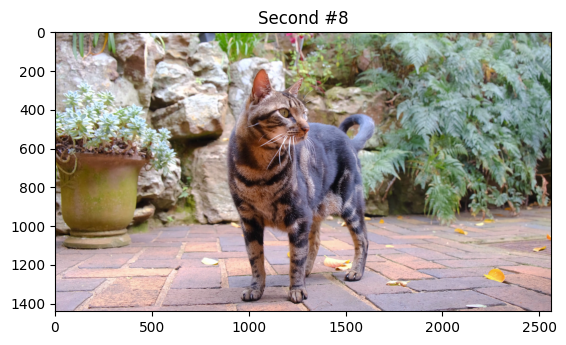

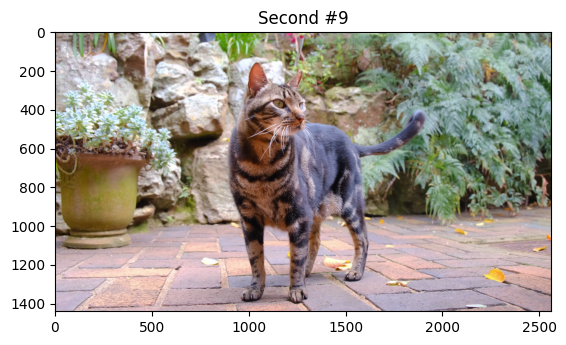

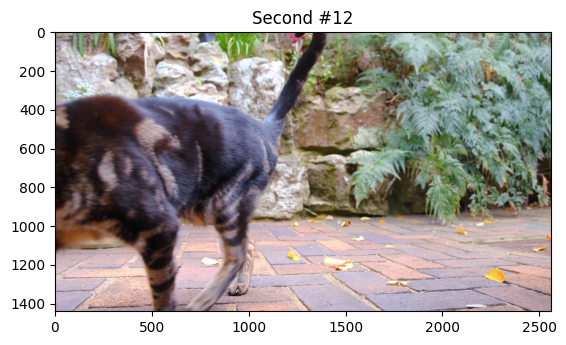

In [4]:
from IPython.display import Video

video = cv2.VideoCapture(video_path)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = video.get(cv2.CAP_PROP_FPS)

print(f"Total Frames: {frame_count}")
print(f"Frames per second: {int(fps)}")


if not video.isOpened():
    print("Failed to open the video")

frames = []
for i in range(frame_count):
    ok, frame = video.read()
    if ok:
        if i % 30 == 0: 
            frames.append(frame)
    else:
        break

for ndx, frame in enumerate(frames):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.title(f"Second #{ndx}")
    plt.imshow(frame)
    plt.show()
        

## How are they represented?

In [5]:
from transformers import AutoTokenizer, CLIPModel, CLIPProcessor
import torch

clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
with torch.no_grad():
    image_inputs = clip_processor(images=image, return_tensors="pt")
    image_embedding = clip_model.get_image_features(**image_inputs)
    print(f"Shape: {image_embedding.shape}")
    print(f"Sample: {image_embedding[0][:5]}...")

Shape: torch.Size([1, 512])
Sample: tensor([-0.3004, -0.5071,  0.0418, -0.3789, -0.1037])...


In [7]:
frames = []
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
for i in range(0, frame_count, frame_count//9):
    video.set(cv2.CAP_PROP_POS_FRAMES, i)
    ok, frame = video.read()
    if ok:
        frames.append(frame)

frame_embeddings = []
for frame in frames:
    with torch.no_grad():
        frame_input = clip_processor(images=frame, return_tensors="pt")
        frame_emb = clip_model.get_image_features(**frame_input)
        frame_embeddings.append(frame_emb)

print(f"Shape: {frame_embeddings[0].shape}")
print(f"Sample: {frame_embeddings[0][0][:50]}...")

Shape: torch.Size([1, 512])
Sample: tensor([ 0.1956,  0.1773, -0.2278, -0.3129, -0.3075, -0.8509,  0.3469,  0.4776,
         0.4835,  0.2520,  0.2092, -0.1061, -0.2337, -0.5698,  0.0943,  0.2345,
         0.0518, -0.0018,  0.5250, -0.0850,  0.6430,  0.5195,  0.3982, -0.3632,
        -0.3339,  0.0496,  0.2778, -0.0751, -0.0061,  0.0944, -0.0400,  0.3773,
        -0.2188,  0.0467,  0.2195,  0.2960,  0.0501, -0.4584,  0.6223,  1.4090,
        -0.6794, -0.0174,  0.1714, -0.1109, -0.0857,  0.3456,  0.0350,  0.0977,
         0.2713, -0.3095])...


### How to choose a tokenizer?

Different models produce different types of embeddings based on what they were designed to learn. For instance, CLIP's image encoder creates embeddings that capture general semantic meaning - understanding objects, scenes, and concepts that can be described in natural language. In contrast, specialized models like deep-person-reid are trained for specific tasks and generate embeddings that emphasize particular features. Deep-person-reid focuses on extracting person-specific characteristics useful for identifying and distinguishing between individuals, so its embeddings highlight attributes like clothing, pose, and appearance details rather than general scene understanding.

# Similarity 

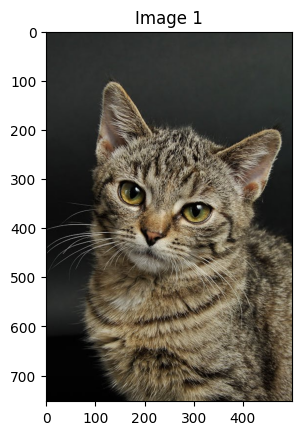

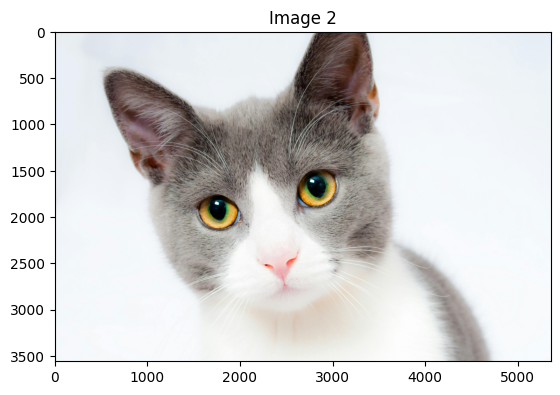

Similarity: 90.18%


In [8]:
image1 = Image.open(image_path)
image2 = Image.open(image_path2)

plt.title("Image 1")
plt.imshow(image1)
plt.show()

plt.title("Image 2")
plt.imshow(image2)
plt.show()

with torch.no_grad():
    image1_inputs = clip_processor(images=image1, return_tensors="pt")
    image1_embedding = clip_model.get_image_features(**image1_inputs)
    image2_inputs = clip_processor(images=image2, return_tensors="pt")
    image2_embedding = clip_model.get_image_features(**image2_inputs)

image_sim_dist = torch.nn.functional.cosine_similarity(image1_embedding, image2_embedding)
print(f"Similarity: {image_sim_dist.item()*100:.2f}%")